<b>1</b> OBTENCIÓN DE DATOS

In [1]:
import definirCorrelacionVariables
from matplotlib import pyplot
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
import seaborn as sns
import pandas as pd
import numpy as np
import pylab as pl

data= definirCorrelacionVariables.getDataFromDataBase()

<b>2</b> pre PROCESAMIENTO DE DATA

In [ ]:
dataframe,datos,dictGeneral = definirCorrelacionVariables.generarMatrizDatos(data,True)

373


3. OBTENCIÓN DE CORRELACIÓN MÚLTIPLE

GRAFICAS ENTRE VARIABLES

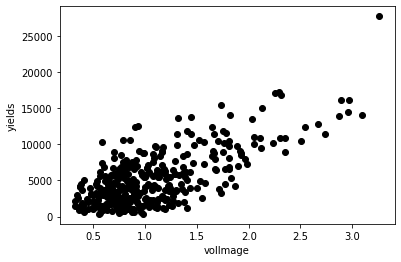

In [ ]:
#pyplot.scatter(datos.datosVolumen, datos.datosVolumenCalculado,c="red")
#pyplot.scatter(datos.datosArea, datos.datosAreaCalculada,c="red")
#pyplot.scatter(datos.datosNdvi, datos.datosVolumenCalculado,c="blue")
#pyplot.scatter(datos.datosAltura, datos.datosNdvi,c="green")
pyplot.scatter(dataframe["volImage"],dataframe["yields"],c="black")
pyplot.xlabel("volImage")
pyplot.ylabel("yields")

pyplot.show()

SE CALCULA LA VARIABLE EL IAF
$Ac = \pi*r*g $

$g = \sqrt(h^2 + r^2) $

Se tiene que $r = Di/2$

$Ac = \pi*r*\sqrt(h^2 + r^2)$

$Ac = \pi*\frac{Di}{4}*\sqrt(4*h^2 + Di^2)$

Diametro

$diameter = 2*\sqrt(\frac{area}{\pi})$

In [ ]:

import math
areaLateral = []
volumeFromDiameter = []
diametros=[]
for index,x in enumerate(datos.datosArea):
    diametro = 2*math.sqrt(x/math.pi)
    diametros.append(diametro)
    altura= datos.datosAlturaCalculada[index]/100
    valueAreaLateral=diametro*math.sqrt((diametro*diametro)+4*(altura*altura))
    valueVolume = math.pi*diametro*diametro*altura*(1/6)
    volumeFromDiameter.append(valueVolume)
    areaLateral.append(valueAreaLateral)


<b style="color:orange;">LAI CALCULATED FROM EQUATION BASED ON VOLUME and AREA</b>

Se calcula el IAF usando Volumen Imagen y Yield

$IAF =  0.0134 + 2.7791 Vc$

Se calcula IAF usando Area Lateral y Yield

$IAF =  -0.5786 + 0.7896 Alat $


In [ ]:

IAF_from_volume = definirCorrelacionVariables.objective(datos.datosVolumenImagen, 2.7791,0.0134)
IAF_from_area = definirCorrelacionVariables.objective(areaLateral, 0.7896,-0.5786)
d = {"latArea":areaLateral, "IAF_VOL":IAF_from_volume, "IAF_AREA":IAF_from_area}
dictGeneral.update(d)
dframeFinal = pd.DataFrame(data=dictGeneral)
pd.options.display.float_format = '{:,.2f}'.format
dataFrameCorrs=dframeFinal.loc[:,["yields","volImage","criMax","IAF_AREA","hImage","tviMin","ndviMax","cgreenviMax"]]
dfCors= dataFrameCorrs.corr(method="pearson")
dfCors.round(decimals=3)
print(dfCors)
dfCors.to_latex("CorrelationsTab.tex")

             yields  volImage  criMax  IAF_AREA  hImage  tviMin  ndviMax  \
yields         1.00      0.71    0.63      0.69    0.50   -0.39     0.55   
volImage       0.71      1.00    0.62      0.99    0.69   -0.46     0.60   
criMax         0.63      0.62    1.00      0.61    0.40   -0.65     0.63   
IAF_AREA       0.69      0.99    0.61      1.00    0.74   -0.45     0.58   
hImage         0.50      0.69    0.40      0.74    1.00   -0.39     0.27   
tviMin        -0.39     -0.46   -0.65     -0.45   -0.39    1.00    -0.30   
ndviMax        0.55      0.60    0.63      0.58    0.27   -0.30     1.00   
cgreenviMax    0.60      0.60    0.91      0.60    0.36   -0.55     0.67   

             cgreenviMax  
yields              0.60  
volImage            0.60  
criMax              0.91  
IAF_AREA            0.60  
hImage              0.36  
tviMin             -0.55  
ndviMax             0.67  
cgreenviMax         1.00  


<h1> USO DE CROSS VAL SCORE </h1>

<b style="color:red;">LINEAR REGRESSION SIMPLE VS MULTIPLE</b>




Non Standard Scaler

REGRESSION MODELS

Linear Regression Simple Predicted  5169.166319967175  Original  5169.166319967175
Linear Regression Multiple 5169.166319967005  Original  5169.166319967175
Lasso Regression Simple Predicted  5169.166319967175  Original  5169.166319967175
Lasso Regression Multiple  5169.166319967176  Original  5169.166319967175
SVR Linear Simple 4934.820268450403  Original  5169.166319967175
SVR Linear Multiple 4887.070666751579  Original  5169.166319967175
SGD Simple Regressor 5163.646323193358  Original  5169.166319967175
SGD Multi Regressor 5160.318816518456  Original  5169.166319967175


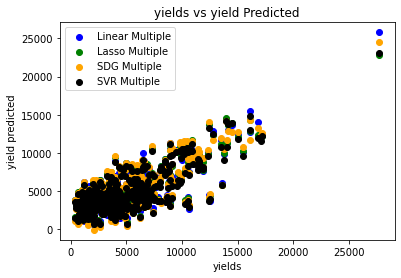

In [ ]:
from cProfile import label
from pickle import FALSE
from sklearn.ensemble import RandomForestRegressor
from sklearn import ensemble
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.isotonic import IsotonicRegression

cantCv=4
scoreDef = "r2" 
#scoreDef="accuracy"
#scoreDef = "explained_variance"
#scoreDef="neg_mean_absolute_error"
dfsX=dframeFinal.loc[:,["volImage"]]
dframeFinal.head()
X_volumenNoScaled= dfsX.values
y_multiple = dframeFinal.yields.values
sc_XMulti = StandardScaler()
sc_X = StandardScaler()
sc_y = StandardScaler()

volumeScaled =  sc_X.fit_transform(X_volumenNoScaled)
yieldNoScaled = dframeFinal.yields.values.reshape(-1, 1)


dfsX=dframeFinal.loc[:,["volImage","criMax","ndviMean","maxBlue","IAF_AREA","maxGreen","saviMax","tviMax","ndviMax","maxHistBluVal"]]
X_multipleNoScaled= dfsX.values
xMultiScaled=sc_XMulti.fit_transform(X_multipleNoScaled)
yieldScaled=sc_y.fit_transform(yieldNoScaled)

model= LinearRegression()
model.fit(X_volumenNoScaled ,yieldNoScaled)
linearSimple=model.predict(X_volumenNoScaled)
print( "Linear Regression Simple Predicted ",np.mean(linearSimple), " Original ",np.mean(yieldNoScaled))


model= LinearRegression()
model.fit(X_multipleNoScaled ,yieldNoScaled)
linearMultiple=model.predict(X_multipleNoScaled)
print( "Linear Regression Multiple",np.mean(linearMultiple), " Original ",np.mean(yieldNoScaled))

model= linear_model.Lasso()
model.fit(X_volumenNoScaled ,yieldNoScaled)
lassoSimple=model.predict(X_volumenNoScaled)
print( "Lasso Regression Simple Predicted ",np.mean(lassoSimple), " Original ",np.mean(yieldNoScaled))

model= linear_model.Lasso()
model.fit(X_multipleNoScaled ,yieldNoScaled)
lassoMultiple=model.predict(X_multipleNoScaled)
print( "Lasso Regression Multiple ",np.mean(lassoMultiple), " Original ",np.mean(yieldNoScaled))

model= SVR(kernel="linear")
model.fit(volumeScaled ,yieldScaled.ravel())
svrLinear=model.predict(volumeScaled)
print( "SVR Linear Simple",np.mean(sc_y.inverse_transform(svrLinear.reshape(1, -1))), " Original ",np.mean(sc_y.inverse_transform(yieldScaled.reshape(1, -1))))


model= SVR(kernel="linear")
model.fit(xMultiScaled ,yieldScaled.ravel())
svrMultiple=model.predict(xMultiScaled)
print( "SVR Linear Multiple",np.mean(sc_y.inverse_transform(svrMultiple.reshape(1, -1))), " Original ",np.mean(sc_y.inverse_transform(yieldScaled.reshape(1, -1))))


model= linear_model.SGDRegressor(loss="squared_error")
model.fit(volumeScaled ,yieldScaled.ravel())
SDGsimple=model.predict(volumeScaled)
SdgReverse=sc_y.inverse_transform(SDGsimple.reshape(1, -1)).ravel()
print( "SGD Simple Regressor",np.mean(SdgReverse), " Original ",np.mean(sc_y.inverse_transform(yieldScaled.reshape(1, -1))))


model= linear_model.SGDRegressor(loss="squared_error")
model.fit(xMultiScaled ,yieldScaled.ravel())
sdgMulti=model.predict(xMultiScaled)
print( "SGD Multi Regressor",np.mean(sc_y.inverse_transform(sdgMulti.reshape(1, -1))), " Original ",np.mean(sc_y.inverse_transform(yieldScaled.reshape(1, -1))))


#pyplot.scatter(yieldNoScaled, linearSimple, color = 'red', label="Linear Simple")
pyplot.scatter(yieldNoScaled, linearMultiple, color = 'blue',label='Linear Multiple')
#pyplot.scatter(yieldNoScaled, lassoMultiple, color = 'green',label='Lasso Multiple')
#pyplot.scatter(yieldNoScaled, sc_y.inverse_transform(sdgMulti.reshape(1, -1)), color = 'orange',label='SDG Multiple')
#pyplot.scatter(yieldNoScaled, sc_y.inverse_transform(svrMultiple.reshape(1, -1)), color = 'black',label='SVR Multiple')
#pyplot.scatter(yieldNoScaled, SdgReverse, color = 'gray',label='SDGmulti')
#pyplot.scatter(yieldNoScaled, rfRegression.predict(X_grid), color = 'black',label='Random Forest')
pyplot.legend()
pyplot.title('yields vs yield Predicted')
pyplot.xlabel('yields')
pyplot.ylabel('yield predicted')

pyplot.show()


